In [1]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl
import os, pickle
# print the JS visualization code to the notebook
shap.initjs()

# Model Setup

Fit the same model as in the census example, on the same data.

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [3]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54663
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.36373
[200]	test-logloss:0.31793
[300]	test-logloss:0.30061
[400]	test-logloss:0.29207
[500]	test-logloss:0.28678
[600]	test-logloss:0.28381
[700]	test-logloss:0.28181
[800]	test-logloss:0.28064
[900]	test-logloss:0.27992
[1000]	test-logloss:0.27928
Stopping. Best iteration:
[999]	test-logloss:0.27927



# Local accuracy checking

## Initial investigation

In [4]:
import pandas as pd
from scipy.special import logit
import matplotlib.pyplot as plt

In [5]:
print("Shap version", shap.__version__)
print("")
# prepare data
R=200     # background size
n_exp=50  # number of instances to explain
X_explain = X_test[:n_exp]
print("Explanation set shape:", X_explain.shape)
background_dataset = pd.DataFrame(X_train.iloc[:R, :])
feat_names=background_dataset.columns
print("Background set shape:", background_dataset.shape)

# explain some examples 
new_explainer = shap.TreeExplainer(model, data=background_dataset)
explanations = new_explainer.shap_values(X_explain)

print("")
# basic expected value checks
print("Expected value", new_explainer.expected_value)
print("base score", params['base_score'])
check_expected = logit(model.predict(xgboost.DMatrix(background_dataset))).mean()
# check the expected value is the average predictn
assert np.abs(check_expected) - np.abs(new_explainer.expected_value) < 1e-4

print("")
# check local accuracy
actual = explanations.sum(1)
expected = logit(model.predict(xgboost.DMatrix(X_test[:n_exp]))) - new_explainer.expected_value 
absolute_error = np.abs(actual - expected)
i_max = np.argmax(absolute_error)
relative_error = np.abs(100*(actual[i_max] - expected[i_max])/expected[i_max])
print("Max Absolute error: {}".format(absolute_error[i_max]))
print("Relative error: {} %.".format(np.round(relative_error, 4)))
new_explainer.assert_additivity(explanations, model.predict(xgboost.DMatrix(X_test[:n_exp], feature_names=feat_names), output_margin=True))

Shap version 0.35.0

Explanation set shape: (50, 12)
Background set shape: (200, 12)

Expected value -2.319641919740286
base score 0.24105497542997542

Max Absolute error: 0.06100169572410785
Relative error: 6.8392 %.


SHAPError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -3.272583, while the model output was -3.211581. If this difference is acceptable you can set check_additivity=False to disable this check.

## Instance level analysis

Compute the shap values for a number of instances, across a range of reference values.

In [6]:
backgrounds = np.split(background_dataset.values, background_dataset.shape[0])


In [10]:
# compute shap values using only 1 reference at a time. This may a bit of time to run

cwd = os.getcwd()
fullpath = os.path.join(cwd, 'shap_vals_samples.pkl')
if os.path.exists(fullpath):
    raise ValueError("Takes a while to run, just unpickle the data in the next cell!")

shap_vals_samples = []
expected_values = []
for i, reference in enumerate(backgrounds):
    tmp_explainer = shap.TreeExplainer(model, data=reference)
    expected_values.append(tmp_explainer.expected_value)
    shap_vals_samples.append(tmp_explainer.shap_values(X_explain)) 
    
data = {'shap_vals_samples': shap_vals_samples, 'expected_values':expected_values}
with open('shap_vals_samples.pkl', 'wb') as f:
    pickle.dump(data, f)

In [12]:
with open('shap_vals_samples.pkl', 'rb') as f:
    data = pickle.load(f)
    
shap_vals_samples = data['shap_vals_samples']
expected_values = data['expected_values']

In [13]:
print("Variance of expected values", np.var(expected_values))
print("Standard dev of expected values", np.sqrt(np.var(expected_values)))

Variance of expected values 8.04014013023714
Standard dev of expected values 2.8355140857060013


We look at the absolute and relative errors for each instance to be explained, across various background samples.

In [14]:
abs_errors, rel_errors, s_actuals, s_expecteds = [], [], [], []
max_abs_errors, max_rel_errors = [], []
argmax_abs_errors, argmax_rel_errors = [], []
min_abs_errors, min_rel_errors = [], []
argmin_abs_errors, argmin_rel_errors = [], []

predictions =  model.predict(xgboost.DMatrix(X_explain), output_margin=True)

for sample, exp_val in zip(shap_vals_samples, expected_values): 
    
    # compute errors
    s_actual = sample.sum(1)
    s_expected = predictions - exp_val
    assert len(s_actual.shape) == len(s_expected.shape) == 1
    abs_error = np.abs(s_actual - s_expected)
    rel_error = np.abs(100*(s_actual - s_expected)/s_expected)
    
    # instances where max of errors occurs
    max_abs_error_idx = np.argmax(abs_error)
    max_rel_error_idx = np.argmax(rel_error)

    # expected and actual sum of shap values
    s_actuals.append(s_actual)
    s_expecteds.append(s_expected)
    
    # absolute and relative errors for all instances
    abs_errors.append(abs_error)
    rel_errors.append(rel_error)
    
    # max absolute and relative errors along with instance info
    argmax_abs_errors.append(max_abs_error_idx)
    argmax_rel_errors.append(max_rel_error_idx)
    max_abs_errors.append(abs_error[max_abs_error_idx])
    max_rel_errors.append(rel_error[max_rel_error_idx])

Plot the results

In [15]:
def plot_errors(errors, **kwargs):
    """
    Scatter plot of error between expected and actual sum of shap values.
    y axis represents the variation of the quantity as a function of the 
    reference sample.
    """
    
    ylabel = kwargs.get('ylabel', 'Error')
    factor = kwargs.get('factor', 3)
    origin = kwargs.get('origin', 1)
    xlabelfontsize =  kwargs.get('xlabelfontsize', 16)
    ylabelfontsize =  kwargs.get('ylabelfontsize', 16)
    xtickfontsize = kwargs.get('xtickfontsize', 12)
    figsize = kwargs.get('figsize', (20, 5))
    
    fig, ax = plt.subplots(figsize=figsize)
    n_references, n_instances = errors.shape
    x_pos = np.arange(n_instances)*factor + origin
    for i, instance_pos in enumerate(x_pos):
        ax.scatter(np.array([instance_pos]*n_references), errors[:,i])
    ax.set_xlabel('Instance', fontsize=xlabelfontsize)
    ax.set_xticks(x_pos[::factor])
    ax.set_xticklabels(((x_pos - origin)).astype(int), fontsize=xtickfontsize)
    ax.set_ylabel(ylabel, fontsize=ylabelfontsize)
    plt.grid(True)

In [16]:
all_abs_errors = np.stack(abs_errors)
all_rel_errors = np.stack(rel_errors)
all_s_actuals = np.stack(s_actuals)
all_s_expected = np.stack(s_expecteds)

We expect both the actual and the expected values to vary as we change the reference.

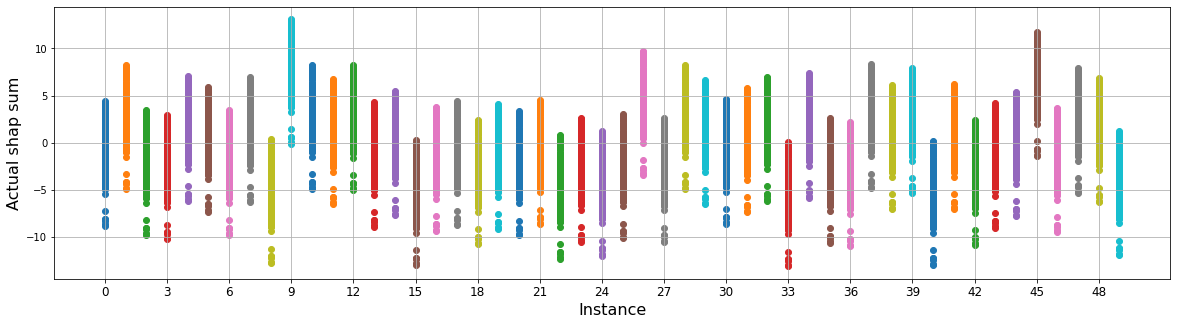

In [17]:
plot_errors(all_s_actuals, ylabel='Actual shap sum')

Figure 1: Actual sum of shap values across instances. Vertical spread is the effect of changing the reference value.

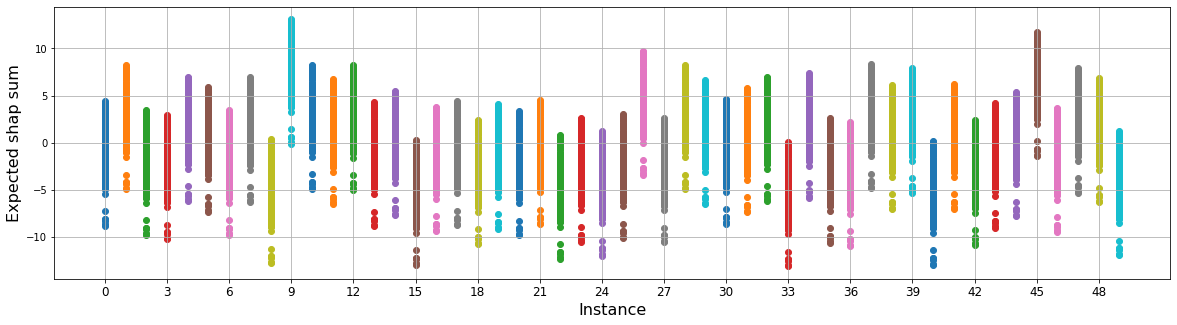

In [18]:
plot_errors(all_s_expected, ylabel='Expected shap sum')

Figure 2: Expected sum of shap values across instances. Vertical spread is the effect of changing the reference value.

For some instances, however, the absolute error between the actual and the expected sum if a fixed constant, irrespective of the reference.

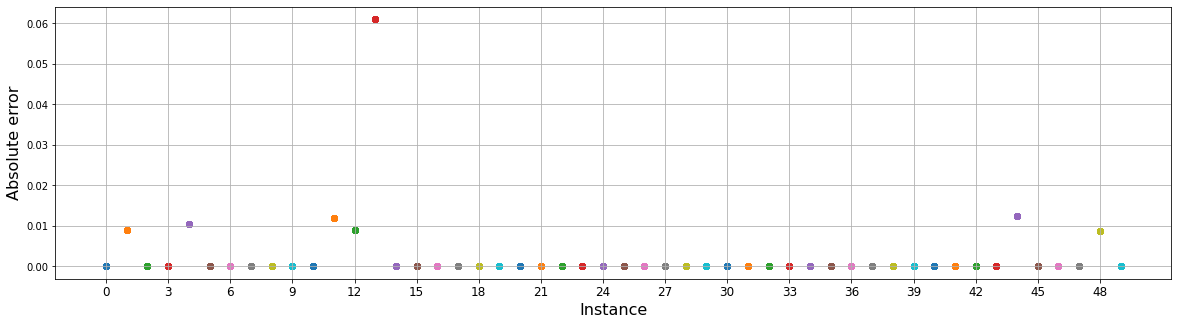

In [19]:
plot_errors(all_abs_errors, ylabel='Absolute error')

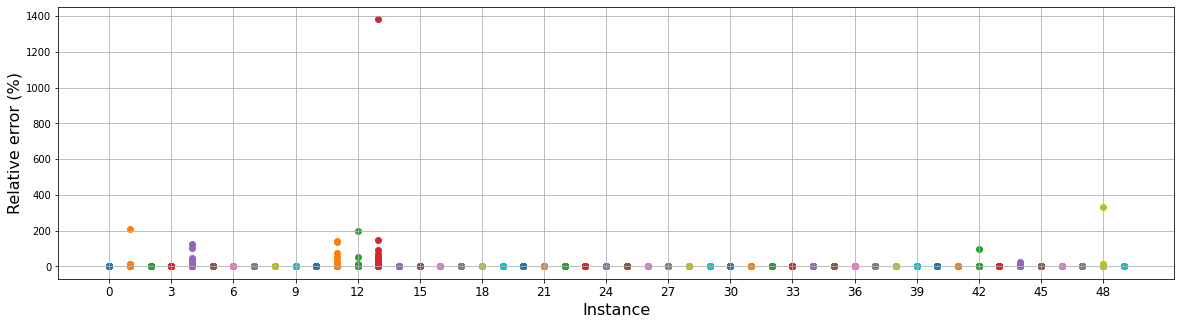

In [20]:
plot_errors(all_rel_errors, ylabel='Relative error (%)')

In [21]:
instance_idx = 13
ref_idx = np.argmax(all_rel_errors[:, instance_idx])
tp = (instance_idx, ref_idx)
print("Max rel error for instance {} (reference {}): {} %".format(*tp, all_rel_errors[ref_idx, instance_idx]))
print("Absolute error for instance {} (reference {}) {}".format(*tp, all_abs_errors[ref_idx, instance_idx]))

# check plot is not nonsense

exp = model.predict(xgboost.DMatrix(X_explain.iloc[instance_idx, :], feature_names=feat_names), output_margin=True) - expected_values[ref_idx]
act = shap_vals_samples[ref_idx][instance_idx, :].sum()
check_rel_err =  np.abs((act - exp)*100/exp)
check_abs_err = np.abs(act - exp)

Max rel error for instance 13 (reference 9): 1381.9084429142124 %
Absolute error for instance 13 (reference 9) 0.06100186066760216


## Shap values variance

In [22]:
shap_variance = np.var(shap_vals_samples, axis=0)

In [26]:
max_var_idx = np.argmax(shap_variance)
min_var_idx = np.argmin(shap_variance)

In [27]:
shap_variance.flatten()[max_var_idx]

2.834872247035292

In [28]:
shap_variance.flatten()[min_var_idx]

0.0014305527616875907